In [1]:
import os
import sys

# Save current working directory
cwd = os.getcwd()

# Change to parent directory
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
os.chdir(parent_dir)

# Temporarily add parent directory to sys.path
sys.path.insert(0, parent_dir)
import framework
sys.path.pop(0)

# Return to original directory
os.chdir(cwd)

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import vit_b_32, ViT_B_32_Weights
from torch import nn, optim
from tqdm import tqdm


weights = ViT_B_32_Weights.DEFAULT
# Transform matching ImageNet-trained model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

from torch import nn

# Load pretrained model
model = vit_b_32(weights=weights)
model.eval()

model.heads = nn.Linear(in_features = 768, out_features = 100, bias = True)

device = "cuda"

In [5]:
import numpy as np

values = {}

for name, params in model.state_dict().items():
    values[name] = np.ravel(params)

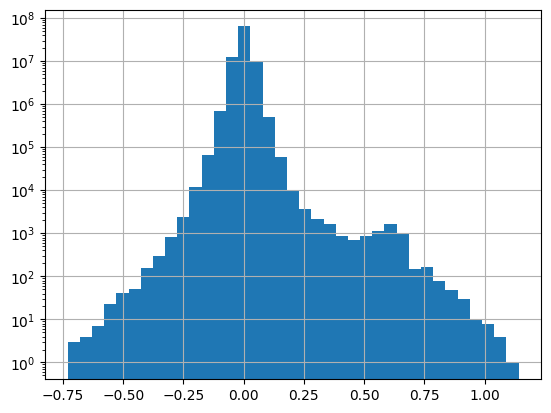

In [61]:
all_vals = np.concatenate(list(values.values()))

import matplotlib.pyplot as plt

min_ = np.min(all_vals)
max_ = np.max(all_vals)

bar_width = 0.05
bins = (max_ - min_) / bar_width

plt.hist(all_vals, bins = int(bins))
plt.yscale("log")
plt.grid()
plt.show()

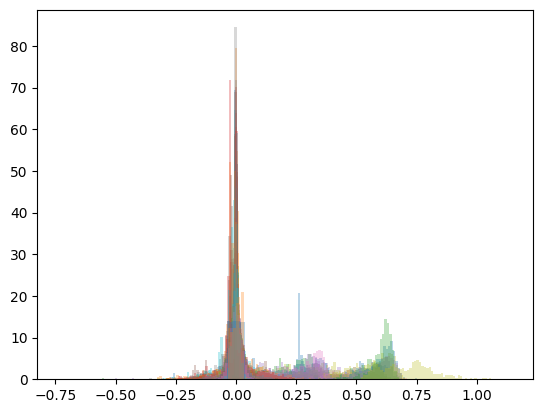

In [36]:
all_vals = np.concatenate(list(values.values()))

import matplotlib.pyplot as plt

for vals in values.values():
    all_vals = vals
    min_ = np.min(all_vals)
    max_ = np.max(all_vals)

    bar_width = 0.01
    bins = (max_ - min_) / bar_width

    plt.hist(all_vals, bins = int(bins), alpha = 0.3, density=True)
    # plt.yscale("log")

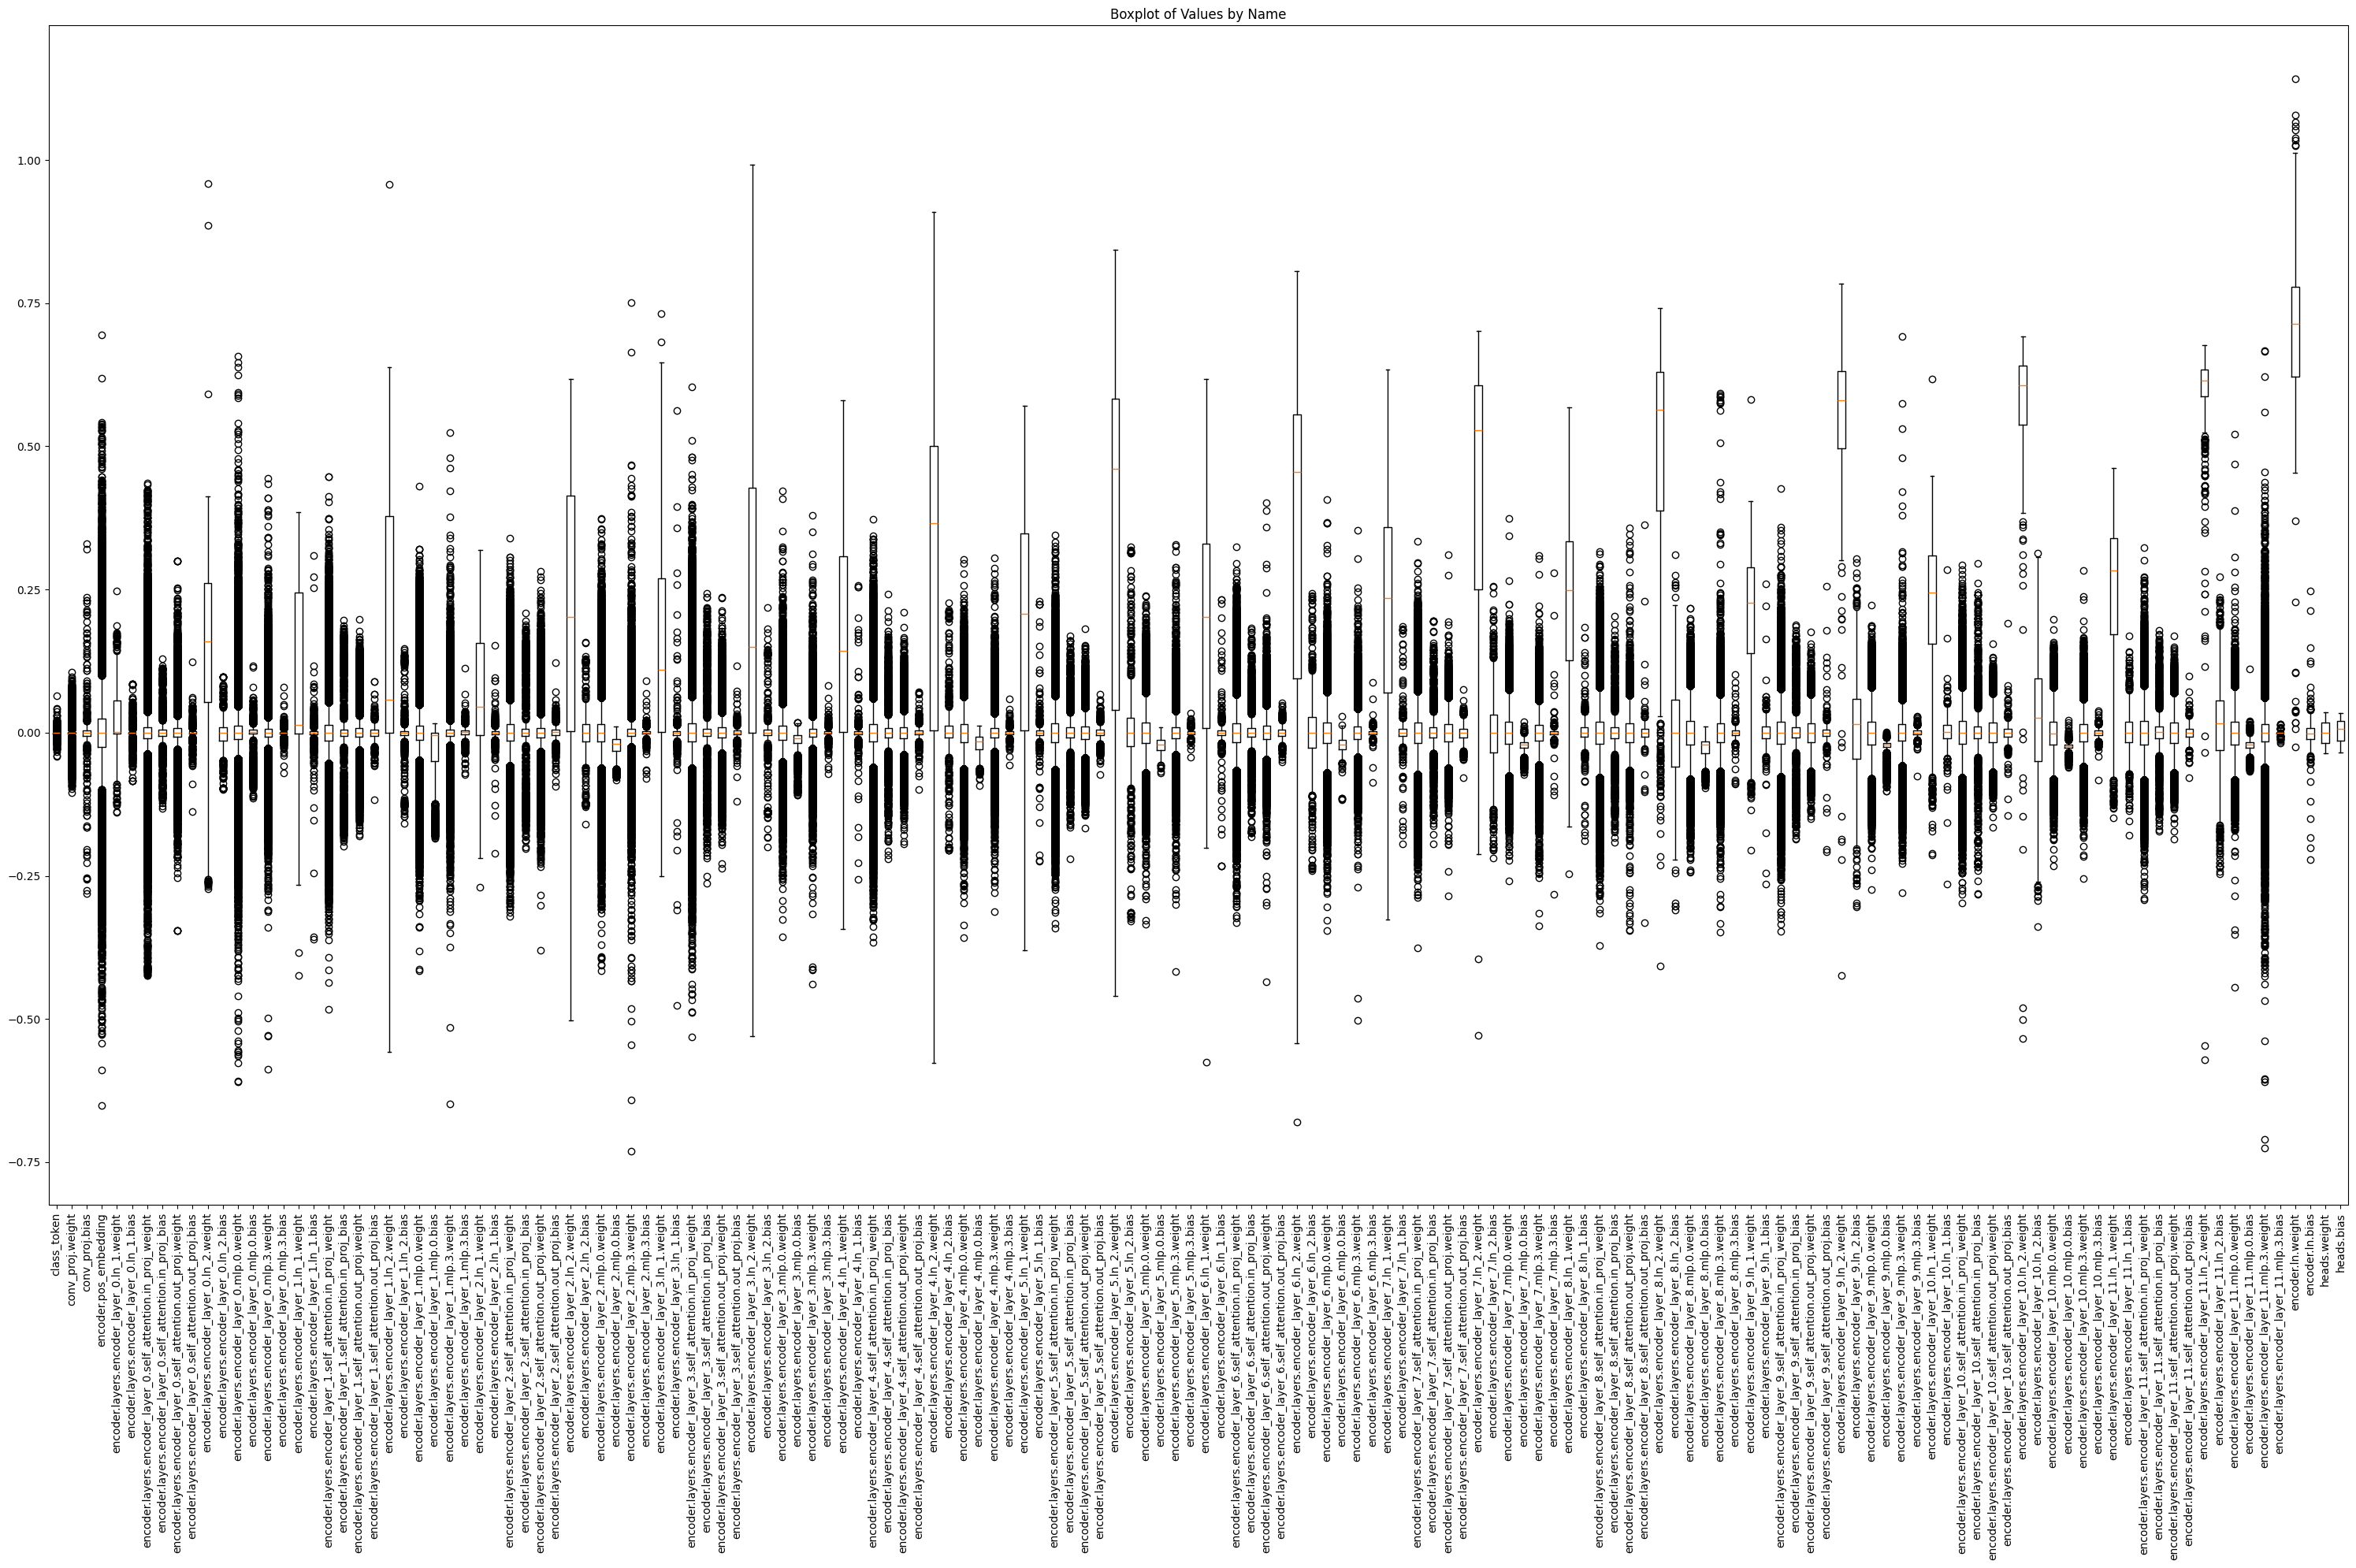

In [41]:
import matplotlib.pyplot as plt

# Boxplot
plt.figure(figsize=(30, 20))
plt.boxplot([v for v in values.values()], tick_labels=values.keys())
plt.xticks(rotation=90)
plt.title('Boxplot of Values by Name')
plt.tight_layout()
plt.show()


In [50]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import random
import itertools
from tqdm import tqdm

# Parameters
SUBSAMPLE_SIZE = 1000
SIMILARITY_P_THRESHOLD = 0.05

# Precompute subsamples
subsamples = {
    name: random.sample(list(vals), min(len(vals), SUBSAMPLE_SIZE))
    for name, vals in values.items()
}

# Pairwise KS tests
names = list(values.keys())
similar_pairs = []

for name1, name2 in tqdm(itertools.combinations(names, 2)):
    s1 = subsamples[name1]
    s2 = subsamples[name2]
    _, p = ks_2samp(s1, s2)
    if p > SIMILARITY_P_THRESHOLD:
        similar_pairs.append((name1, name2, p))

# Output
print("Statistically similar distributions (p > 0.05):")
for i, j, p in sorted(similar_pairs, key=lambda x: -x[2]):
    print(f"{i} ~ {j} (p = {p:.3f})")


11476it [00:18, 614.61it/s]

Statistically similar distributions (p > 0.05):
encoder.layers.encoder_layer_10.mlp.0.weight ~ encoder.layers.encoder_layer_11.mlp.0.weight (p = 0.988)
encoder.layers.encoder_layer_6.mlp.3.bias ~ encoder.layers.encoder_layer_7.mlp.3.bias (p = 0.984)
encoder.layers.encoder_layer_8.self_attention.in_proj_weight ~ encoder.layers.encoder_layer_9.mlp.0.weight (p = 0.980)
encoder.layers.encoder_layer_2.mlp.3.bias ~ encoder.layers.encoder_layer_3.mlp.3.bias (p = 0.973)
encoder.layers.encoder_layer_5.mlp.0.weight ~ encoder.layers.encoder_layer_6.self_attention.in_proj_weight (p = 0.969)
encoder.layers.encoder_layer_7.mlp.3.weight ~ encoder.layers.encoder_layer_11.mlp.3.weight (p = 0.954)
encoder.layers.encoder_layer_8.mlp.3.weight ~ encoder.layers.encoder_layer_11.self_attention.out_proj.weight (p = 0.954)
encoder.layers.encoder_layer_0.self_attention.in_proj_weight ~ encoder.layers.encoder_layer_5.self_attention.out_proj.weight (p = 0.936)
encoder.layers.encoder_layer_8.self_attention.out_pro

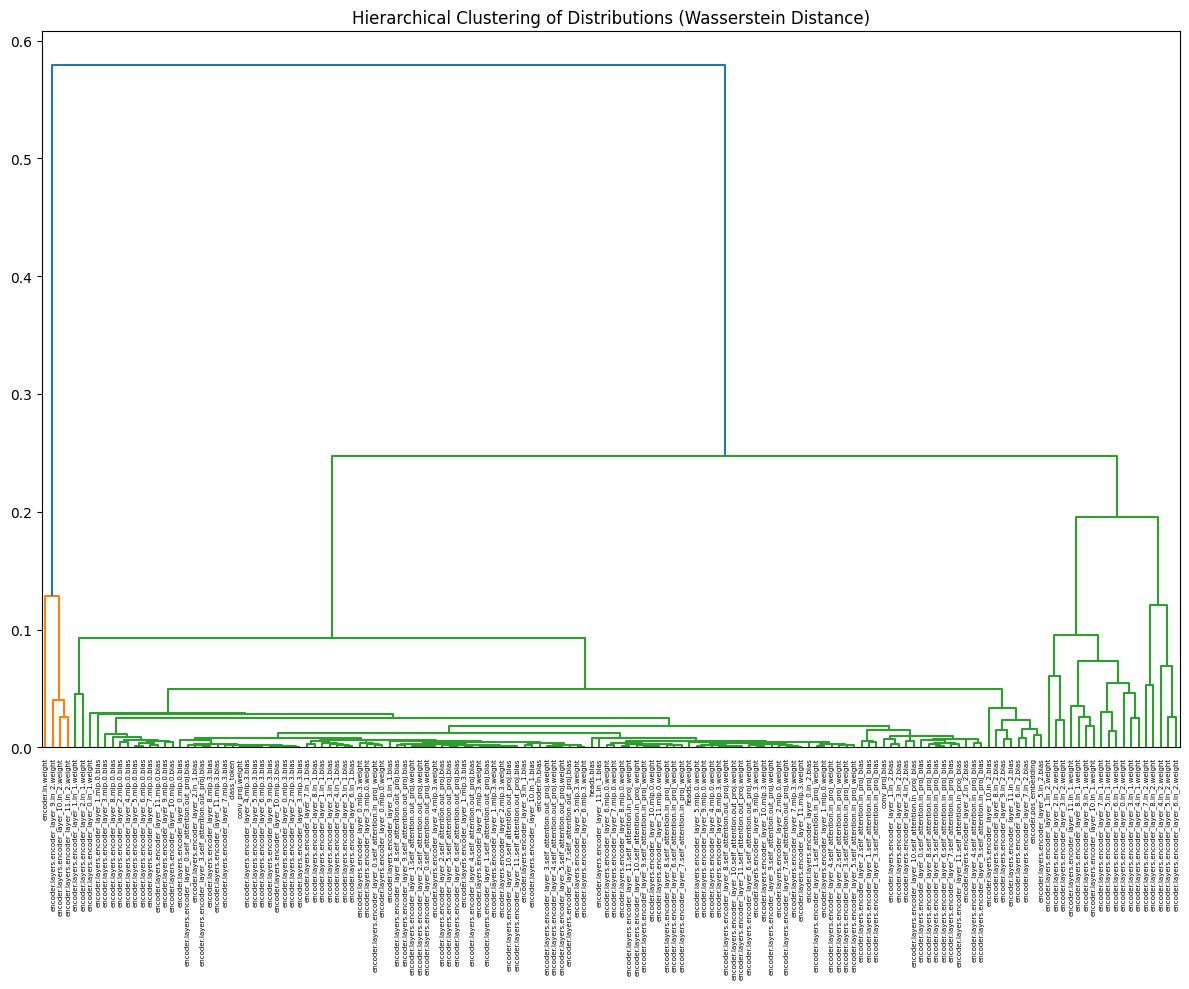

In [57]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import wasserstein_distance
import numpy as np

# Step 1: Compute pairwise distance matrix
names = list(subsamples.keys())
n = len(names)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        d = wasserstein_distance(subsamples[names[i]], subsamples[names[j]])
        dist_matrix[i, j] = dist_matrix[j, i] = d

# Step 2: Condensed distance matrix for clustering
condensed = dist_matrix[np.triu_indices(n, k=1)]

# Step 3: Hierarchical clustering (linkage)
Z = linkage(condensed, method='average')  # or 'ward', 'complete', etc.

# Step 4: Plot dendrogram
plt.figure(figsize=(12, 10))
dendrogram(Z, labels=names, leaf_rotation=90)
plt.title("Hierarchical Clustering of Distributions (Wasserstein Distance)")
plt.tight_layout()
plt.show()


In [58]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Cut dendrogram to get cluster labels (e.g., max 10 clusters)
max_clusters = 10
cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

# Group names by cluster
clusters = {}
for name, cl in zip(names, cluster_labels):
    clusters.setdefault(cl, []).append(name)

# Print cluster summaries
for cl, members in clusters.items():
    print(f"Cluster {cl} ({len(members)} members): {members[:5]}{'...' if len(members) > 5 else ''}")


Cluster 4 (128 members): ['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight']...
Cluster 7 (6 members): ['encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_1.weight', 'encoder.layers.encoder_layer_4.ln_1.weight', 'encoder.layers.encoder_layer_5.ln_1.weight', 'encoder.layers.encoder_layer_6.ln_1.weight']...
Cluster 3 (2 members): ['encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_2.ln_1.weight']
Cluster 5 (3 members): ['encoder.layers.encoder_layer_1.ln_2.weight', 'encoder.layers.encoder_layer_2.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_2.weight']
Cluster 10 (1 members): ['encoder.layers.encoder_layer_4.ln_2.weight']
Cluster 9 (2 members): ['encoder.layers.encoder_layer_5.ln_2.weight', 'encoder.layers.encoder_layer_6.ln_2.weight']
Cluster 8 (2 members): ['encoder.layers.encoder_layer_7.ln_2.weight', 'encoder.layers.encoder_layer_8.ln_2.weight']
Cluster 6

c:\Repositories\seu-injection-framework\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


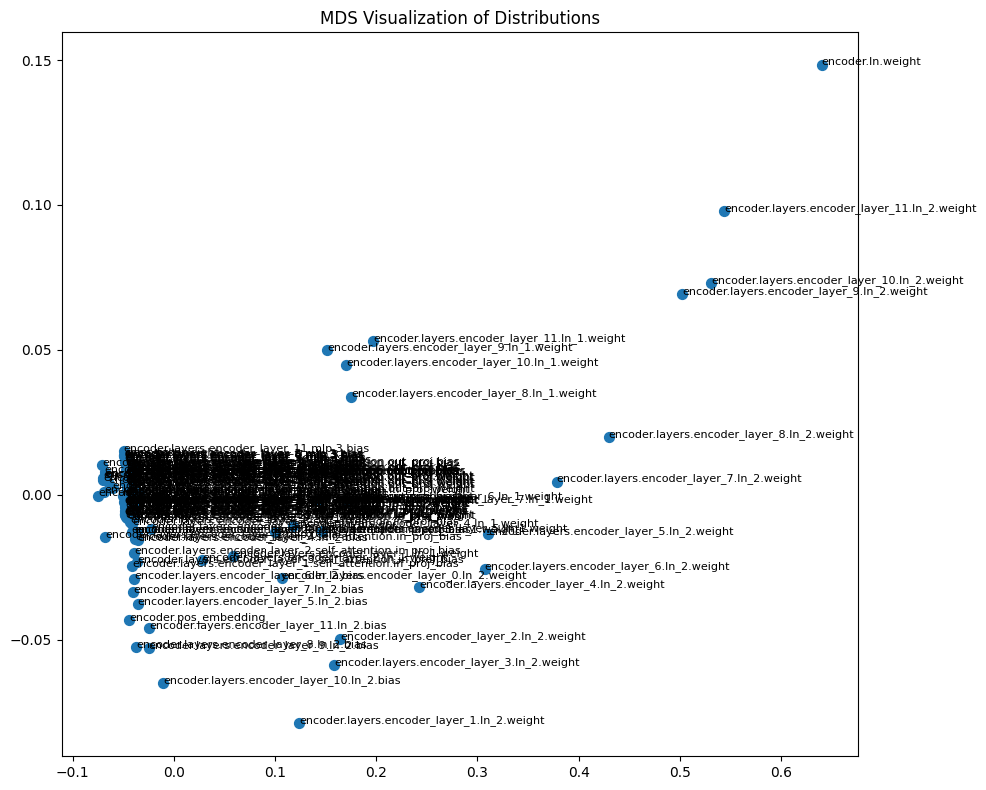

In [59]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
coords = mds.fit_transform(dist_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=50)

for i, name in enumerate(names):
    plt.text(coords[i, 0], coords[i, 1], name, fontsize=8)

plt.title("MDS Visualization of Distributions")
plt.tight_layout()
plt.show()


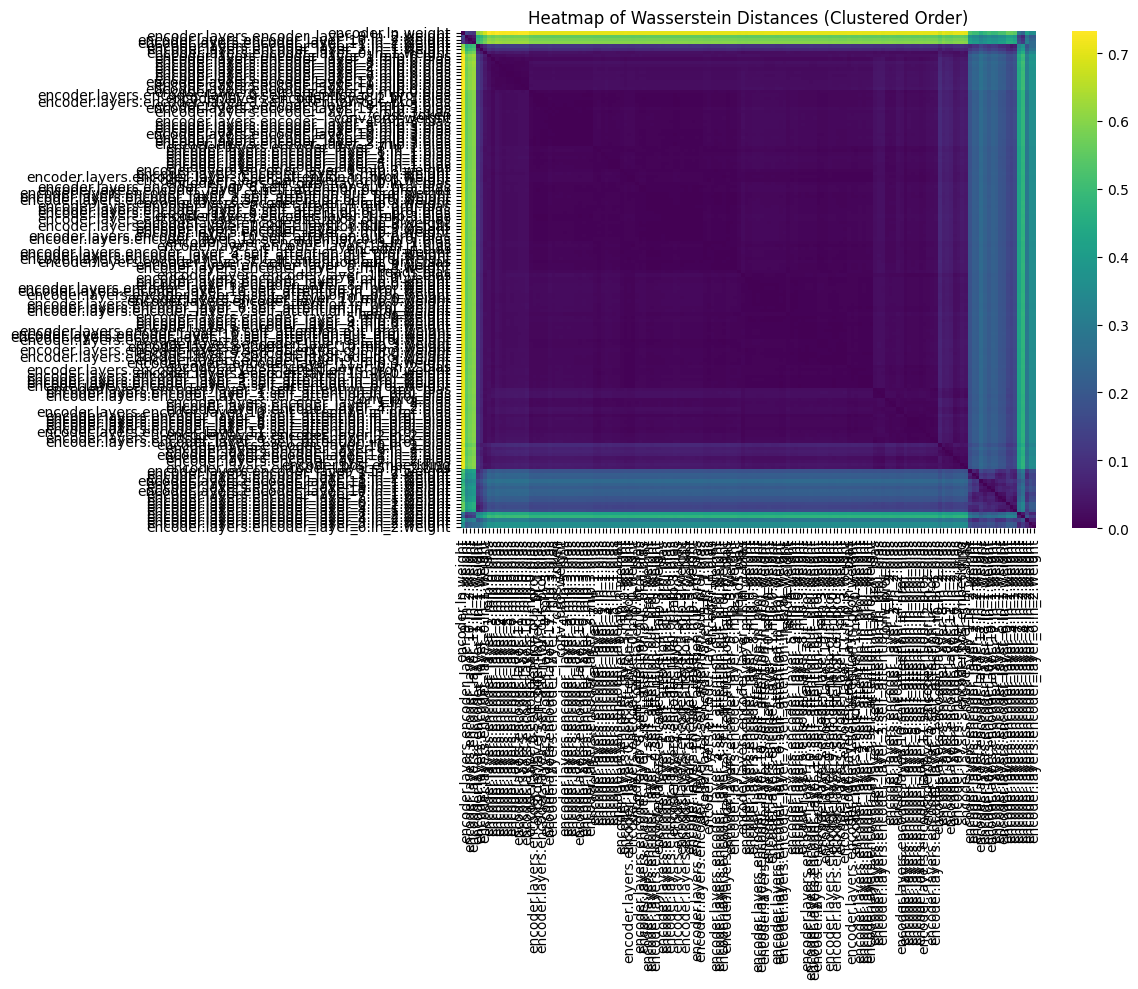

In [60]:
import seaborn as sns
import numpy as np

# Order names by dendrogram leaf order
leaf_order = dendrogram(Z, no_plot=True)['leaves']
ordered_dist = dist_matrix[np.ix_(leaf_order, leaf_order)]

plt.figure(figsize=(12, 10))
sns.heatmap(ordered_dist, xticklabels=np.array(names)[leaf_order], yticklabels=np.array(names)[leaf_order],
            cmap='viridis')
plt.title("Heatmap of Wasserstein Distances (Clustered Order)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also u

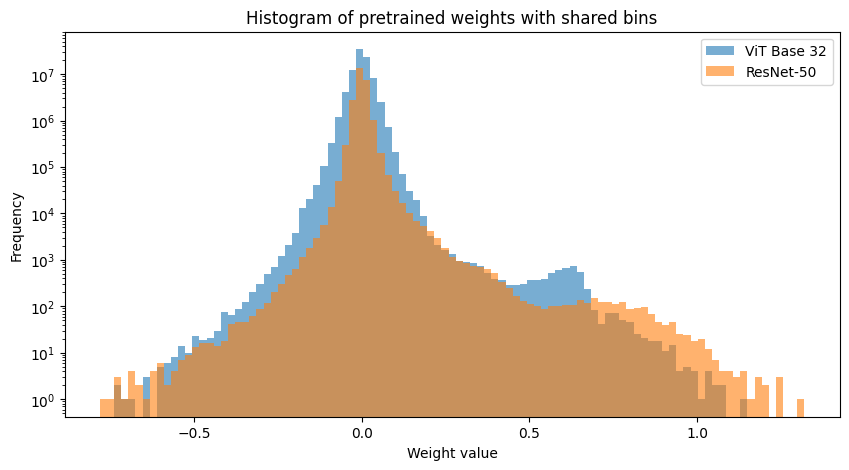